In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import shap
import pandas as pd
import os
import src.utils as utils
import src.classifier as clf
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from src.preprocess import TextCleaner
from src.preprocess import ColumnSelector
from src.preprocess import TypeSelector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

In [2]:
path = os.getcwd()
labels = pd.read_table(path + '/resources/data/corpus_machismo_etiquetas.csv', sep=";")
labels = labels[["status_id","categoria"]]
tweets_fields = pd.read_csv(path + '/resources/data/corpus_machismo_frodriguez_atributos_extra.csv', 
                            dtype={'status_id': 'str'})
tweets_fields.head()

,filename,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,termino
0,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,154970429,1013567568039366661,2018-07-01 23:38:34,valunaticx,hoy a la mañana me quisieron levantar a un aut...,Twitter for Android,106,NaN,NaN,...,10537,2010-06-12 18:54:29,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/15497042...,http://abs.twimg.com/images/themes/theme10/bg.gif,http://pbs.twimg.com/profile_images/1010928341...,feminazi
1,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,996795854123134977,1013555580680667136,2018-07-01 22:50:56,MillaZapata,@funesmemoriosa @Leaobutron Lo que pasa es que...,Twitter for Android,86,1.013498e+18,50198488.0,...,1326,2018-05-16 16:53:46,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/99679585...,NaN,http://pbs.twimg.com/profile_images/9967992596...,feminazi
2,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,577431222,1013556044096733184,2018-07-01 22:52:46,beluluque1,Anoche a la salida del boliche dos chicos tira...,Twitter for iPhone,276,NaN,NaN,...,2949,2012-05-11 18:14:59,False,NaN,NaN,en,https://pbs.twimg.com/profile_banners/57743122...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9516401268...,feminazi
3,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,87143378,1013492312205398017,2018-07-01 18:39:31,rubinho_152,@tjcope y va la tonta y pregunta por la prensa...,Twitter Lite,81,NaN,182330628.0,...,6,2009-11-03 08:33:03,False,NaN,NaN,en,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/sticky/default_profile_im...,"""a fregar"""
4,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,870191034311069697,1013430666539790336,2018-07-01 14:34:34,killwthlove,"Que no me cuentes tu vida, niñata. https://t.c...",Twitter for Android,34,NaN,NaN,...,1258,2017-06-01 08:11:24,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/87019103...,NaN,http://pbs.twimg.com/profile_images/1012329454...,ninata


In [3]:
x_cols2 = ['text','source', 'display_text_width', 'respuesta', 'respuesta_screen_name',
          'favorite_count', 'retweet_count', 'hastag_presence',
          'url_presence', 'media_type', 'mentions_presence',
          'followers_count', 'friends_count', 'listed_count', 'statuses_count',
          'favourites_count', 'verified', 'categoria']
tweets_fields = utils.change_dtypes(tweets_fields, {'status_id': str})
labels = utils.change_dtypes(labels, {'status_id': str})
tweets_labeled = tweets_fields.merge(labels, on = 'status_id', how = 'inner')
tweets_labeled['respuesta'] = np.where(tweets_labeled['reply_to_status_id'].isnull(), 'no', 'si')
tweets_labeled['respuesta_screen_name'] = np.where(tweets_labeled['reply_to_screen_name'].isnull(), 'no', 'si') 
tweets_labeled['hastag_presence'] = np.where(tweets_labeled['hashtags'].isnull(), 'no', 'si') 
tweets_labeled['url_presence'] = np.where(tweets_labeled['urls_url'].isnull(), 'no', 'si') 
tweets_labeled['mentions_presence'] = np.where(tweets_labeled['mentions_user_id'].isnull(), 'no', 'si') 
dudosos_dict = {"DUDOSO": "MACHISTA"}
#tweets_labeled = tweets_labeled.replace({"categoria" :dudosos_dict})
#tweets_labeled = utils.downsample(tweets_labeled, 'NO_MACHISTA', 267)
#tweets_labeled = utils.downsample(tweets_labeled, 'MACHISTA', 267)
#tweets_labeled = tweets_labeled.loc[80:100,:]
#tweets_labeled = tweets_labeled.loc[0:100,:]
tweets_labeled.head()
categorical_features = ['source', 'respuesta', 'respuesta_screen_name',
          'hastag_presence', 'url_presence',
          'media_type', 'mentions_presence', 'verified']
for f in categorical_features:
    tweets_labeled[f] = tweets_labeled[f].astype("category")

In [4]:
x_cols = ['source', 'display_text_width', 'respuesta', 'respuesta_screen_name',
          'favorite_count', 'retweet_count', 'hastag_presence',
          'url_presence', 'media_type', 'mentions_presence',
          'followers_count', 'friends_count', 'listed_count', 'statuses_count',
          'favourites_count', 'verified']
classifier = 'logistic_regression'
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            SimpleImputer(strategy="constant"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="constant", fill_value = "NA"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)
        
preprocessor = TextCleaner(filter_users=True, filter_hashtags=True, 
                           filter_urls=True, convert_hastags=True, lowercase=True, 
                           replace_exclamation=True, replace_interrogation=True, 
                           remove_accents=True, remove_punctuation=True, replace_emojis=True)   
     
text_pipeline = Pipeline([
    ('column_selection', ColumnSelector('text')),
    ('tfidf', TfidfVectorizer(tokenizer=utils.tokenizer_, 
                                          smooth_idf=True, preprocessor = preprocessor,
                                          norm=None, min_df=0.01, ngram_range=(1,1)))
])  
    
union_pipeline = Pipeline([('feature-union', FeatureUnion([('text-features', text_pipeline), 
                               ('other-features', preprocess_pipeline)
                              ]))
                          ])

In [5]:

dataset_tfidf = union_pipeline.fit_transform(tweets_labeled[x_cols2]).todense()
numeric = tweets_labeled[x_cols2].select_dtypes(include=np.number).columns.tolist()
categorical = preprocess_pipeline.steps[1][1].transformer_list[1][1].steps[2][1].get_feature_names().tolist()
columns = text_pipeline.named_steps['tfidf'].get_feature_names() + numeric + categorical
df = pd.DataFrame(dataset_tfidf, columns = columns)

In [6]:
df.shape

(3600, 222)

In [7]:
df.to_csv("tfidf.csv")

In [8]:
tweets_labeled[x_cols2].shape

(3600, 18)

In [9]:
df.head()

,2,ahi,ahora,alguien,amiga,anda,ano,aqui,asi,aunqu,...,x3_no,x3_si,x4_no,x4_si,x5_NA,x5_photo,x6_no,x6_si,x7_False,x7_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [10]:
from sklearn.model_selection import train_test_split
#num_dict = {"DUDOSO": 3, "MACHISTA": 1, "NO_MACHISTA" : 2}
#tweets_labeled = tweets_labeled.replace({"categoria" :num_dict})
X_train, X_test, y_train, y_test = train_test_split(df, tweets_labeled['categoria'], test_size=0.1, random_state=7)
#classifier = clf.get_classifier('svm')
classifier = clf.get_classifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
#y_pred


In [29]:
X_test.head()
predicciones = X_test
predicciones = predicciones.assign(y_pred = pd.Series(y_pred).values, y_real = pd.Series(y_test).values)
predicciones.head()
predicciones.to_csv("predicciones.csv")
#tweets_labeled[x_cols2].to_csv("texto_predicciones.csv")

In [11]:
classifier.classes_

array(['DUDOSO', 'MACHISTA', 'NO_MACHISTA'], dtype=object)

In [67]:
tweets_labeled.iloc[3034]['text']

'@CopitoDeSnow_ Ahora es cuando digo "no est\xc3\xa1 mal para ser mujer"'

In [13]:
#explainer = shap.KernelExplainer(classifier.predict_proba, X_train)
explainer = shap.LinearExplainer(classifier, X_train)
# Calculate Shap values
shap_values = explainer.shap_values(X_test)
#tweets_labeled['categoria']

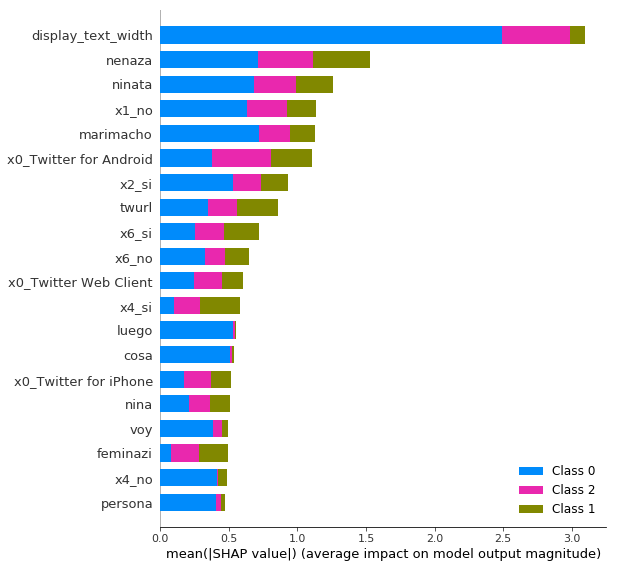

In [14]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


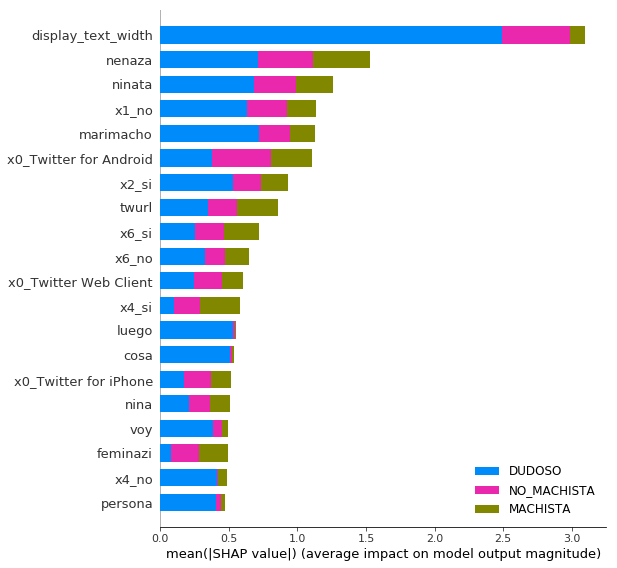

In [15]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_names = classifier.classes_)

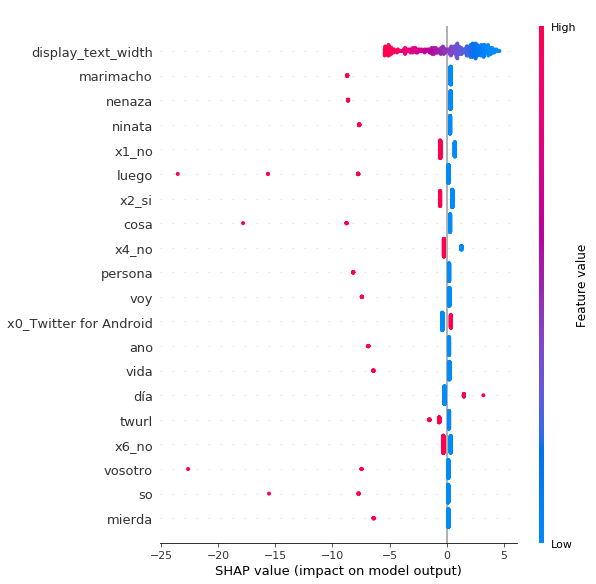

In [16]:
#DUDOSO
shap.summary_plot(shap_values[0], X_test)


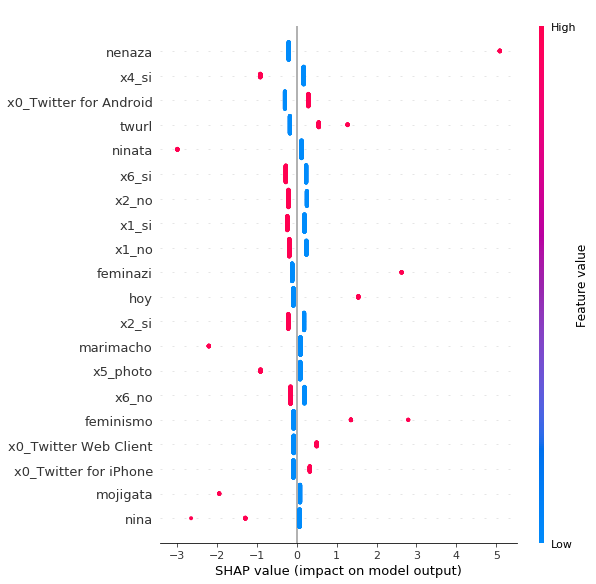

In [17]:
#MACHISTA
shap.summary_plot(shap_values[1], X_test)


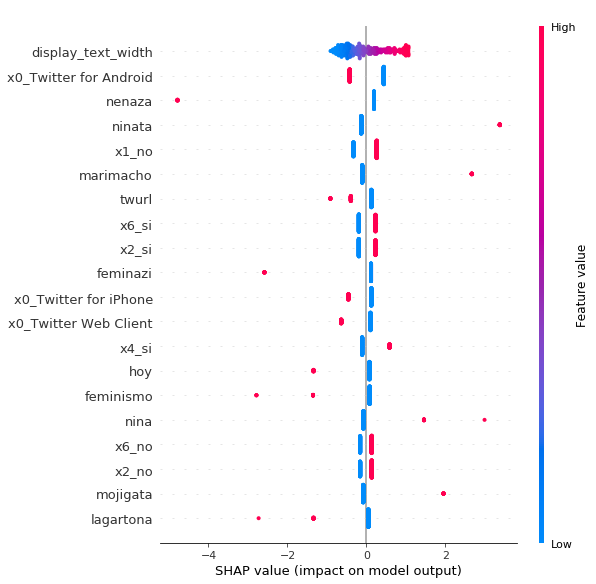

In [18]:
#NO MACHISTA
shap.summary_plot(shap_values[2], X_test)


In [125]:
tweets_labeled.iloc[1801]['text']

'@Pajaropolitico @claualtamirano huele a feminazi! atentos que en Argentina y Espa\xc3\xb1a estan incontrolables, cuotas laborales y lenguaje inclusivo son algunas de las estupideces que impulsan. el feminismo no tiene razon de ser, porque ante la ley no hay nada que un hombre haga que no pueda hacer una mujer'

In [127]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][200,:], X_test.iloc[200,:])


In [68]:
X_test.iloc[50]

2                         0.00000
ahi                       0.00000
ahora                     4.63509
alguien                   0.00000
amiga                     0.00000
anda                      0.00000
ano                       0.00000
aqui                      0.00000
asi                       0.00000
aunqu                     0.00000
bien                      0.00000
buena                     0.00000
bueno                     0.00000
cada                      0.00000
call                      0.00000
cara                      0.00000
casa                      0.00000
cocina                    0.00000
cono                      0.00000
constant                  0.00000
cosa                      0.00000
creo                      0.00000
cuenta                    0.00000
dar                       0.00000
de                        0.00000
deberian                  0.00000
decir                     0.00000
deja                      0.00000
despué                    0.00000
dice          